# General k-means analysis
Created by Vanessa King <br>
Initiated May 13, 2021

In [13]:
import math
import time
import random
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches
import numpy as np
from numpy import linalg
import scipy.io as sio
from sklearn.cluster import KMeans
from sklearn import metrics
from matplotlib.ticker import FormatStrFormatter
import pandas as pd



%matplotlib notebook

In [2]:
#Description:
#Uploads data that has been preprocessed in Matlab
#In the format of a '.mat' Matlab matrix

def MATLAB_file_to_array(fileName, variableName):
    #fileName should be string of the full path and fileName
    #variableName should be string of workspace variable name as it was in MATLAB
    
    matrix = sio.loadmat(fileName)
    array = matrix[variableName]
    print("Shape of array: ",np.shape(array))
    
    return array

jisun_data_A = MATLAB_file_to_array('/Users/vanessa/Desktop/UBC/Lab/Iridates_Project/Jisun_Data/dIdV_A.mat','didv_A')
#Before using the data, need it to be in shape (x, y, energy):
jisun_data_A = np.transpose(jisun_data_A)
print("Shape of array after transposing: ",np.shape(jisun_data_A))

jisun_data_C = MATLAB_file_to_array('/Users/vanessa/Desktop/UBC/Lab/Iridates_Project/Jisun_Data/didv_C.mat','didv_C')
#Before using the data, need it to be in shape (x, y, energy):
jisun_data_C = np.transpose(jisun_data_C)
print("Shape of array after transposing: ",np.shape(jisun_data_C))

Shape of array:  (499, 64, 64)
Shape of array after transposing:  (64, 64, 499)
Shape of array:  (499, 57, 57)
Shape of array after transposing:  (57, 57, 499)


In [3]:
def my_kmeans(file, n_clusters):
    #Data needs to be in shape (n_samples, n_features), ie: (75625, 81)
    data = np.reshape(file, (np.shape(file)[0]*np.shape(file)[1], np.shape(file)[2]))
    # https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++',n_init=100, max_iter=100, random_state=0, algorithm='full').fit(data)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    
    #https://scikit-learn.org/stable/modules/clustering.html#calinski-harabasz-index
    #Calinski-Harabasz Index for quality of fit evaluation. A high value signifies a good fit. Equals BCSS / WCSS
    score = metrics.calinski_harabasz_score(data, labels)
    #print('k-means complete. BCSS / WCSS = {:0.6e}'.format(score))
    
    return labels, centroids, score


#   Description:
#plotting function for k-means output
#   Parameters:
#Inputs:
#grid = array of dI/dV grid map in shape (x, y, energy)
#minV = float, the first energy value
#maxV = float, the last energy value
#labels = array, output of k-mean cluster assignments in shape (x, y)
#centroids = array, output of k-means centroids in shape (number_clusters, energy)
#colours = array of strings, desired colour for each centroid
#Outpus: None

def kmeans_Plot(grid, minV, maxV, labels, centroids, colours):
    energy = np.linspace(minV, maxV, num=np.shape(grid)[2]) #evenly spaced values between minV and maxV
    img_labels = np.reshape(labels, (np.shape(grid)[0],np.shape(grid)[1])) #Reformating labels for map layout
    number_centroids = np.shape(centroids)[0]
    
    #Plotting
    fig,(ax1,ax2) = plt.subplots(1,2)
    fig.subplots_adjust(hspace=0.3)
    
    for i in range(number_centroids):
        if i == 1:
            ax1.plot(energy,centroids[i],label='Centroid '+str(i+1), marker='',linestyle='-', lw=2, color=colours[i])
        elif i == 5:
            ax1.plot(energy,centroids[i],label='Centroid '+str(i+1), marker='',linestyle='-', lw=2, color=colours[i])
        
    
    ax1.set_ylabel("DOS")
    ax1.set_xlabel("Bias (eV)")
    ax1.set_title("k-means centroids")
    ax1.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
    ax1.legend()
    
    cmap = colors.ListedColormap(colours)
    ax2.imshow(img_labels, cmap=cmap)
    ax2.set_title("Map of cluster assignments")
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    
    plt.show()


In [21]:
labels, centroids, score = my_kmeans(jisun_data_C, 8)
    

k-means complete. BCSS / WCSS = 4.516775e+02


<IPython.core.display.Javascript object>


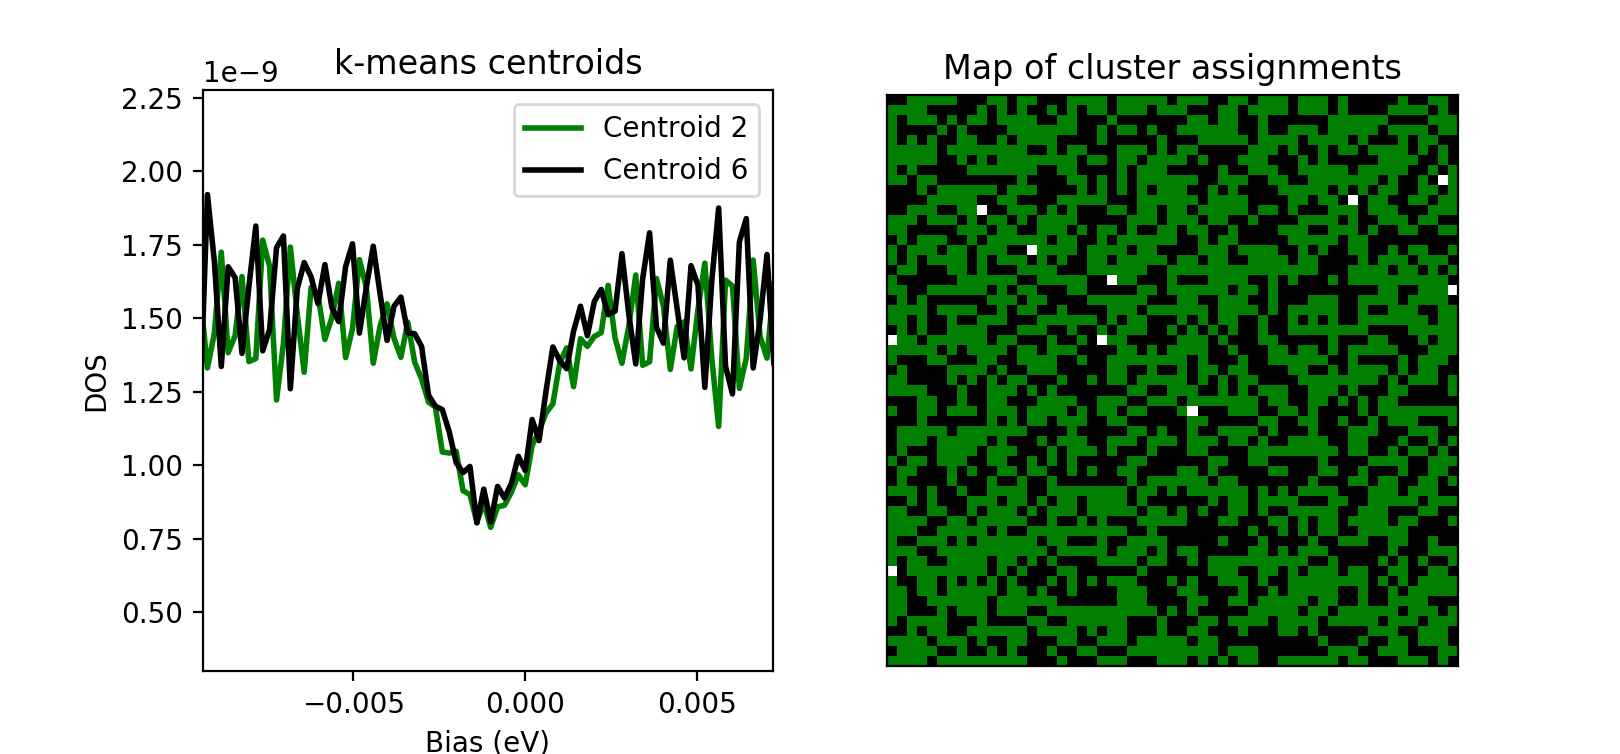

In [43]:
kmeans_Plot(jisun_data_C,-0.05,0.05,labels,centroids,['w','g','w','w','w','k','w','w'])

#save to cluster assignments to file
#np.savetxt("Rh18_4K_3cluster_labels.csv", img_labels, delimiter=',')

<IPython.core.display.Javascript object>


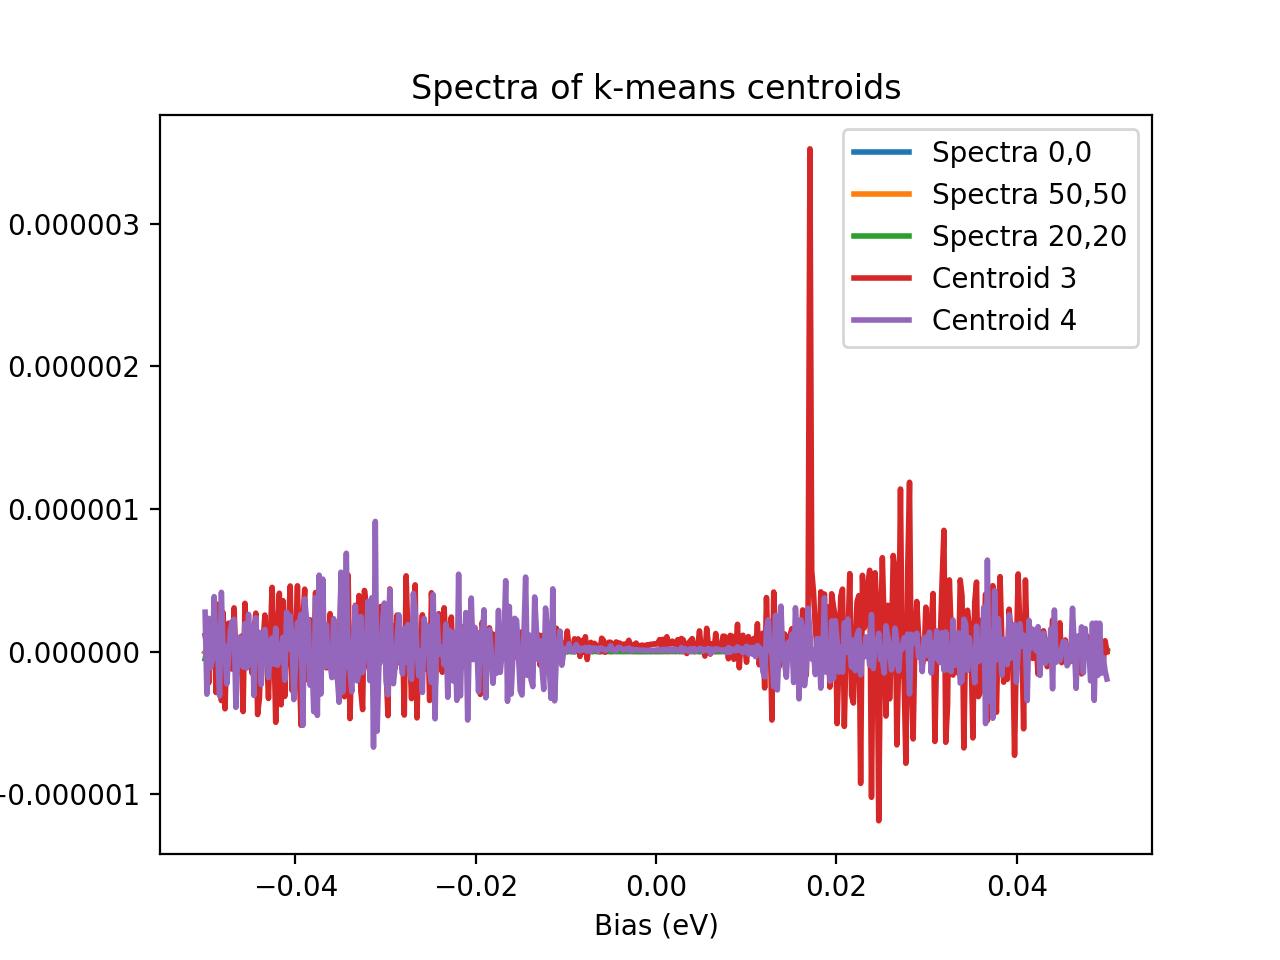

In [12]:
#Plotting a random sample of spectra

energy = np.linspace(-0.05, 0.05, num=np.shape(jisun_data_C)[2])

fig, ax = plt.subplots()
ax.plot(energy,jisun_data_C[0][0],label="Spectra 0,0", marker='',linestyle='-',lw=2)
ax.plot(energy,jisun_data_C[50][50],label="Spectra 50,50", marker='',linestyle='-',lw=2)
ax.plot(energy,jisun_data_C[20][20],label="Spectra 20,20", marker='',linestyle='-',lw=2)
ax.plot(energy,centroids[2],label="Centroid 3", marker='',linestyle='-',lw=2)
ax.plot(energy,centroids[3],label="Centroid 4", marker='',linestyle='-',lw=2)
ax.set_ylabel("DOS")
ax.set_xlabel("Bias (eV)")
ax.set_title("Spectra of k-means centroids")
ax.legend()

# Simulated Data Analysis<br>

Generating and then testing k-means on simulated data. Goal is to understand the limits of k-means when it comes to seeing clusters through the noise. <br>
Part 1: Mott gap and pseudogap 2-cluster data. Using the background, Mott, and pseudogap functions as they are defined in 'SpectraFitting.ipynb'.

$DOS_B = c_0* V^3 + c_1* V^2 + c_2* V + c_3$ <br>

$DOS_M = c_4*\left| \frac{1}{1+\exp\left(\frac{V-E_0}{\omega}\right)} - \frac{1}{1+\exp\left(\frac{-V+E_0-\Delta_M}{\omega}\right)} \right|$ <br>

$DOS_P = \mathbb{Re}\left(c_5*\left| \frac{|V|+i*\alpha\sqrt{|V|}}{\sqrt{\left(|V|+i*\alpha\sqrt{|V|}\right)^2- \Delta_P^2}}\right|\right)$ <br>

$E_0$ is the chemical potential. <br>
$\omega$ is a broadening of the edge of the Mott gap. <br>
$\Delta_M$ is the size of the Mott gap. <br>
$\alpha$ is an effective scattering rate. <br>
$\Delta_P$ is the size of the pseudogap. <br>


In [4]:
#DOS cubic background: f(V)
def DOS_B(params, V): # params = [c0, c1, c2, c3]
    c0 = params[0]
    c1 = params[1]
    c2 = params[2]
    c3 = params[3]
    return c0*V**3 + c1*V**2 + c2*V + c3

#DOS Mott: f(V)
def DOS_M(params, V):# params = [c4, M]
    c4 = params[0]
    M = params[1]
    E0 = 0.52
    w = 0.02
    return c4*np.abs(1 / (1+np.exp((V-E0) / w)) - 1 / (1+np.exp((-V+E0-M) / w)))

#DOS Pseudogap: f(V)
def DOS_P(params, V):# params = [c5, P, a]
    c5 = params[0]
    P = params[1]
    a = params[2]
    
    answer = np.array(c5*np.abs( (np.abs(V) + 1j*a*np.sqrt(np.abs(V))) / np.sqrt( (np.abs(V) + 1j*a*np.sqrt(np.abs(V)))**2 - P**2)))
    return answer.real #Taking only the real part of the function

In [5]:
# DOS B + M:
def DOS_BM(params, V): # params = [c0, c1, c2, c3, c4, M]
    c0 = params[0]
    c1 = params[1]
    c2 = params[2]
    c3 = params[3]
    c4 = params[4]
    M = params[5]
    
    background = DOS_B([c0, c1, c2, c3], V)
    mott = DOS_M([c4, M], V)
    
    sum_bm = [background[i]+mott[i] for i in range(len(V))]
    return sum_bm

#DOS B + P:
def DOS_BP(params, V): # params = [c0, c1, c2, c3, c5, P, a]
    c0 = params[0]
    c1 = params[1]
    c2 = params[2]
    c3 = params[3]
    c5 = params[4]
    P = params[5]
    a = params[6]
    
    background = DOS_B([c0, c1, c2, c3], V)
    pseudogap = DOS_P([c5, P, a], V)
    
    sum_bp = [background[i]+pseudogap[i] for i in range(len(V))]
    return sum_bp

#DOS B + M + P:
def DOS_BMP(params, V): # params = [c0, c1, c2, c3, c4, M, c5, P, a]
    c0 = params[0]
    c1 = params[1]
    c2 = params[2]
    c3 = params[3]
    c4 = params[4]
    M = params[5]
    c5 = params[6]
    P = params[7]
    a = params[8]
    
    background = DOS_B([c0, c1, c2, c3], V)
    mott = DOS_M([c4, M], V)
    pseudogap = DOS_P([c5, P, a], V)
    
    sum_bmp = [background[i]+mott[i]+pseudogap[i] for i in range(len(V))]
    return sum_bmp
    

In [6]:
#Define bias values

V = np.linspace(-0.1, 0.8, 100) #0eV to 0.8eV

#Choice values for the function parameters:
c0 = -1.5 #Cubic background term
c1 = 1.0 #Quadratic background term
c2 = 0.85 #Linear background term
c3 = 0.0 #0th order background term
c4 = 0.6 #Mott term coeffecient
c5 = 0.3 #Pseudogap term coeffecient
M = 0.6 #Size of Mott gap in eV
P = 0.12 #Size of pseudogap in eV
a = 0.2 # depth of pseudogap

(4, 81)


<IPython.core.display.Javascript object>


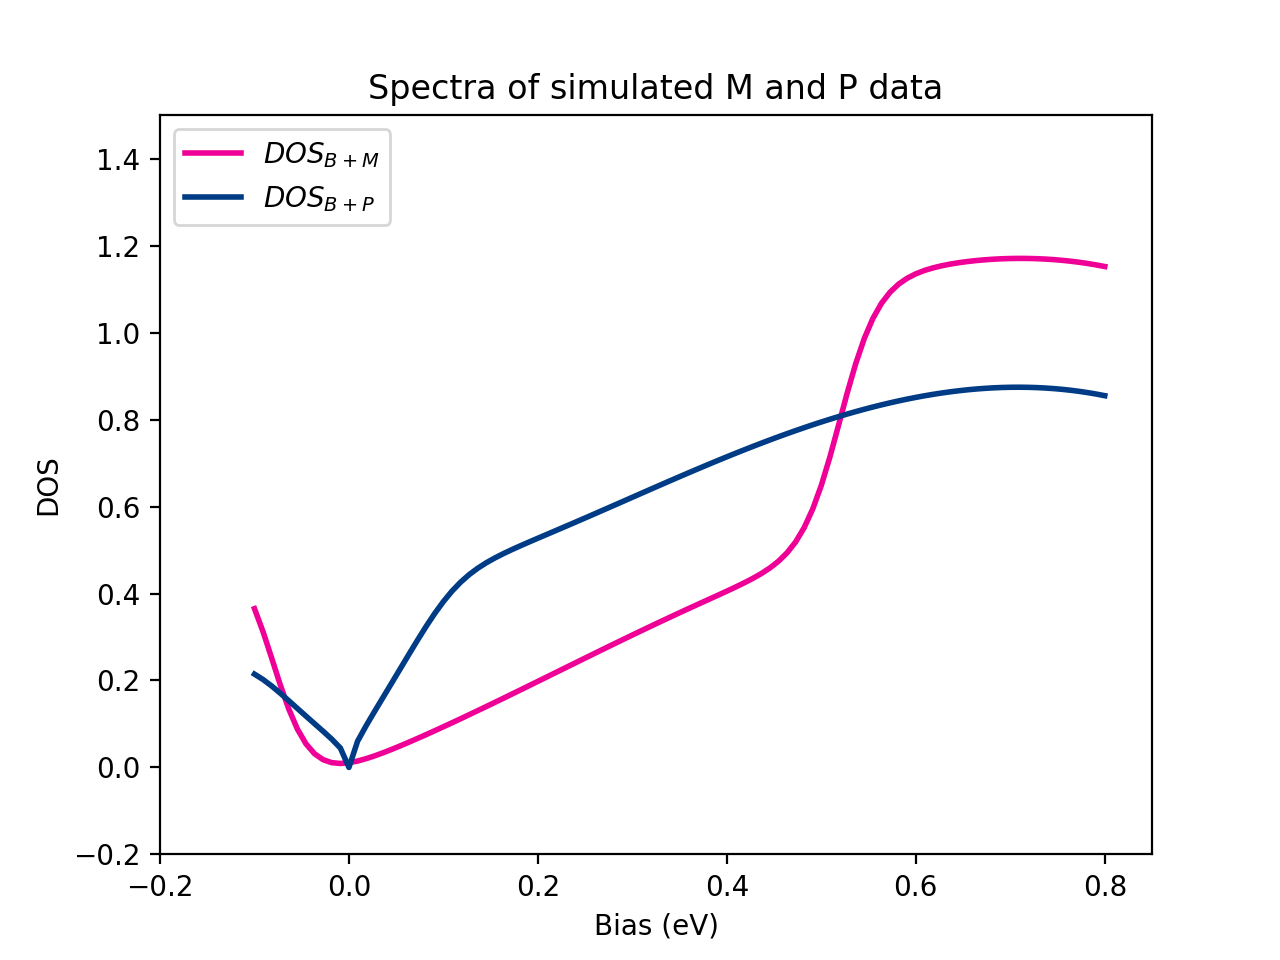

In [14]:
#Import kMeans centroids

sample_dataframe = pd.read_csv("Rh5_4K_4cluster_centroids.csv", sep = ",", header = None)
sample_centroids = sample_dataframe.values
sample_centroids = sample_centroids*1.0E11
sample_energy = np.linspace(-0.8,0.8,81)
print(np.shape(sample_centroids))


#Plotting
#Note on colour: '#003C86' is navy for P1
#                '#EF0096' is magenta for M
#                'k' is black for DEFFECT
#                '#00DCB5'is teal for P2

fig,(ax1) = plt.subplots()
fig.subplots_adjust(hspace=0.3)
    
ax1.plot(V,DOS_BM([c0,c1,c2,c3,c4,M],V),label=r"$DOS_{B+M}$", marker='',linestyle='-', lw=2, markersize=1.5, color='#EF0096')
ax1.plot(V,DOS_BP([c0,c1,c2,c3,c5,P,a],V),label=r"$DOS_{B+P}$", marker='',linestyle='-', lw=2, markersize=1.5, color='#003C86')
#ax1.plot(V,DOS_BMP([c0,c2,c2,c3,c4,M,c5,P,a],V),label="BMP", marker='.',linestyle='-', lw=1, markersize=1.5, color='k')
#ax1.plot(sample_energy,DOS_B([c0,c1,c2,c3],sample_energy),label="B", marker='',linestyle='-', lw=1, color='k')


#ax1.plot(sample_energy,sample_centroids[0],label="Centroid M", marker='',linestyle='-', lw=2, color='#EF0096')
#ax1.plot(sample_energy,sample_centroids[1],label="Centroid D", marker='',linestyle='-', lw=2, color='k')
#ax1.plot(sample_energy,sample_centroids[2],label="Centroid P2", marker='',linestyle='-', lw=2, color='#00DCB5')
#ax1.plot(sample_energy,sample_centroids[3],label="Centroid P1", marker='',linestyle='-', lw=2, color='#003C86')


ax1.set_ylabel("DOS")
ax1.set_xlabel("Bias (eV)")
ax1.set_title("Spectra of simulated M and P data")
ax1.legend(loc="upper left")
ax1.set_ylim(-0.2, 1.5)
ax1.set_xlim(-0.2,0.85)
    

plt.show()


In [19]:
#Simulated Mott and pseudogap Data Generator: 
def generate_M_and_P_data(params, V, dimensions, ratio, noise):
    #Inputs:
    #params = [c0,c1,c2,c3,c4,M,c5,P,a] set values
    #V = array of bias values
    #dimensions = integer array of desired grid map spatial dimensions, [grid x length, grid y length]
    #ratio = array of floats, the probability values for Mott vs pseudogap pixels. Must sum to 1. ie, [0.40, 0.60]
    #noise = float, the standard deviation of gaussian noise added to spectra. 
    
    #Outputs:
    #grid = 3D array [grid width, grid length, bias length] of simulated grid map
    #identities = 2D array [grid width, grid length], of true pixel identities. 0=Mott, 1=pseudogap.
    
    #First, assign random identities:
    rng = np.random.default_rng(12345)#Creating a generator and seeding it
    flat_identities = rng.choice([0,1], size=dimensions[0]*dimensions[1], replace=True, p=ratio)#Choose identities
    identities = np.reshape(flat_identities,(dimensions[0],dimensions[1]))
    
    #Second, generate 'true' grid map
    c0 = params[0]
    c1 = params[1]
    c2 = params[2]
    c3 = params[3]
    c4 = params[4]
    M = params[5]
    c5 = params[6]
    P = params[7]
    a = params[8]
    
    BM_spectrum = DOS_BM([c0,c1,c2,c3,c4,M],V)
    BP_spectrum = DOS_BP([c0,c1,c2,c3,c5,P,a],V)
    
    grid = [[0 for j in range(dimensions[1])] for i in range(dimensions[0])]
    for i in range(dimensions[0]):
        for j in range(dimensions[1]):
            if identities[i][j] == 0: #a.k.a., identity is Mott
                grid[i][j] = BM_spectrum
            else: #a.k.a., identity is pseudogap
                grid[i][j] = BP_spectrum
    
    #Third, add noise to the spectra
    #Noise is gaussian and proportional to the bias magnitude
    gaussian_noise = rng.normal(loc=0.0, scale=noise, size=(dimensions[0],dimensions[1],len(V)))
    
    grid = grid + V*gaussian_noise
    
    return grid, identities

#Test the accuracy of the k-means given the true identities:
def accuracy_test(identities,labels):
    #Inputs: 
    #indentities = array of size grid width x grid length, output from data generation function
    #labels = array of size grid width x grid length, output from my_kmeans
    #Outputs:
    #percentage = float of the percentage of spectra kmeans succesfully classified
    
    flat_identities = identities.flatten()
    
    #Note: whether k-means labels 0 as 0 or as 1 is arbitrary, so we need to test to find out which is the case
    counter_A = 0
    counter_B = 0
    for i in range(len(flat_identities)):
        if flat_identities[i] != labels[i]:
            counter_A+=1
        else:
            counter_B+=1
            
    percentage = 1.0 - np.amin([counter_A,counter_B]) / float(len(flat_identities))
    return percentage


#Function to run through a range of noise values on Mott and pseudogap simulated data and record the quality of 
#the k-means classification.
def kmeans_MP_noise_test(params, V, dimensions, ratio, noise_values):
    #Inputs:
    #params = [c0,c1,c2,c3,c4,M,c5,P,a] set values
    #V = array of bias values
    #dimensions = integer array of desired grid map spatial dimensions, [grid x length, grid y length]
    #ratio = array of floats, the probability values for Mott vs pseudogap pixels. Must sum to 1. ie, [0.40, 0.60]
    #noise_values = array of noise values to test, ie: [0.0, 0.2, 0.4, 0.6]. 
    
    #Outputs:
    #percentages = array of percentage failures values
    
    percentages = [0 for i in range(len(noise_values))]
    scores = [0 for i in range(len(noise_values))]
    
    for i in range(len(noise_values)):
        grid, identities = generate_M_and_P_data(params, V, dimensions, ratio, noise_values[i])
        labels, centroids, score = my_kmeans(grid, 2)
        percentage = accuracy_test(identities, labels)
        
        percentages[i] = percentage*100
        scores[i] = score
        
    return percentages, scores
        

In [20]:
V = np.linspace(-0.1, 0.8, 100) #0eV to 0.8eV
grid_x = 50 #How many pixels in x
grid_y = 50 #How many pixels in y
test_grid, test_identities = generate_M_and_P_data([c0,c1,c2,c3,c4,M,c5,P,a], V, [grid_x,grid_y],[0.5,0.5],0.2)
true_BM_spectrum = DOS_BM([c0,c1,c2,c3,c4,M],V)
true_BP_spectrum = DOS_BP([c0,c1,c2,c3,c5,P,a],V)
test_labels, test_centroids, test_scores = my_kmeans(test_grid,2)


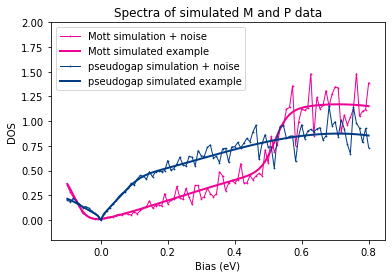

In [12]:
#Plotting
#Note on colour: '#003C86' is navy for P1
#                '#EF0096' is magenta for M
#                'k' is black for DEFFECT
#                '#00DCB5'is teal for P2

fig,(ax1) = plt.subplots()
fig.subplots_adjust(hspace=0.3)
    
ax1.plot(V,test_grid[0][0],label="Mott simulation + noise", marker='.',linestyle='-', lw=1, markersize=1.5, color='#EF0096')
ax1.plot(V,true_BM_spectrum,label="Mott simulated example", marker='',linestyle='-', lw=2, markersize=1.5, color='#EF0096')

ax1.plot(V,test_grid[10][10],label="pseudogap simulation + noise", marker='.',linestyle='-', lw=1, markersize=1.5, color='#003C86')
ax1.plot(V,true_BP_spectrum,label="pseudogap simulated example", marker='',linestyle='-', lw=2, markersize=1.5, color='#003C86')


#ax1.plot(sample_energy,sample_centroids[0],label="Centroid M", marker='',linestyle='--', lw=1, color='#EF0096')
#ax1.plot(sample_energy,sample_centroids[3],label="Centroid P1", marker='',linestyle='--', lw=1, color='#003C86')


ax1.set_ylabel("DOS")
ax1.set_xlabel("Bias (eV)")
ax1.set_title("Spectra of simulated M and P data")
ax1.legend()
ax1.set_ylim(-0.2, 2.0)
ax1.set_xlim(-0.15,0.85)

plt.show()

<IPython.core.display.Javascript object>


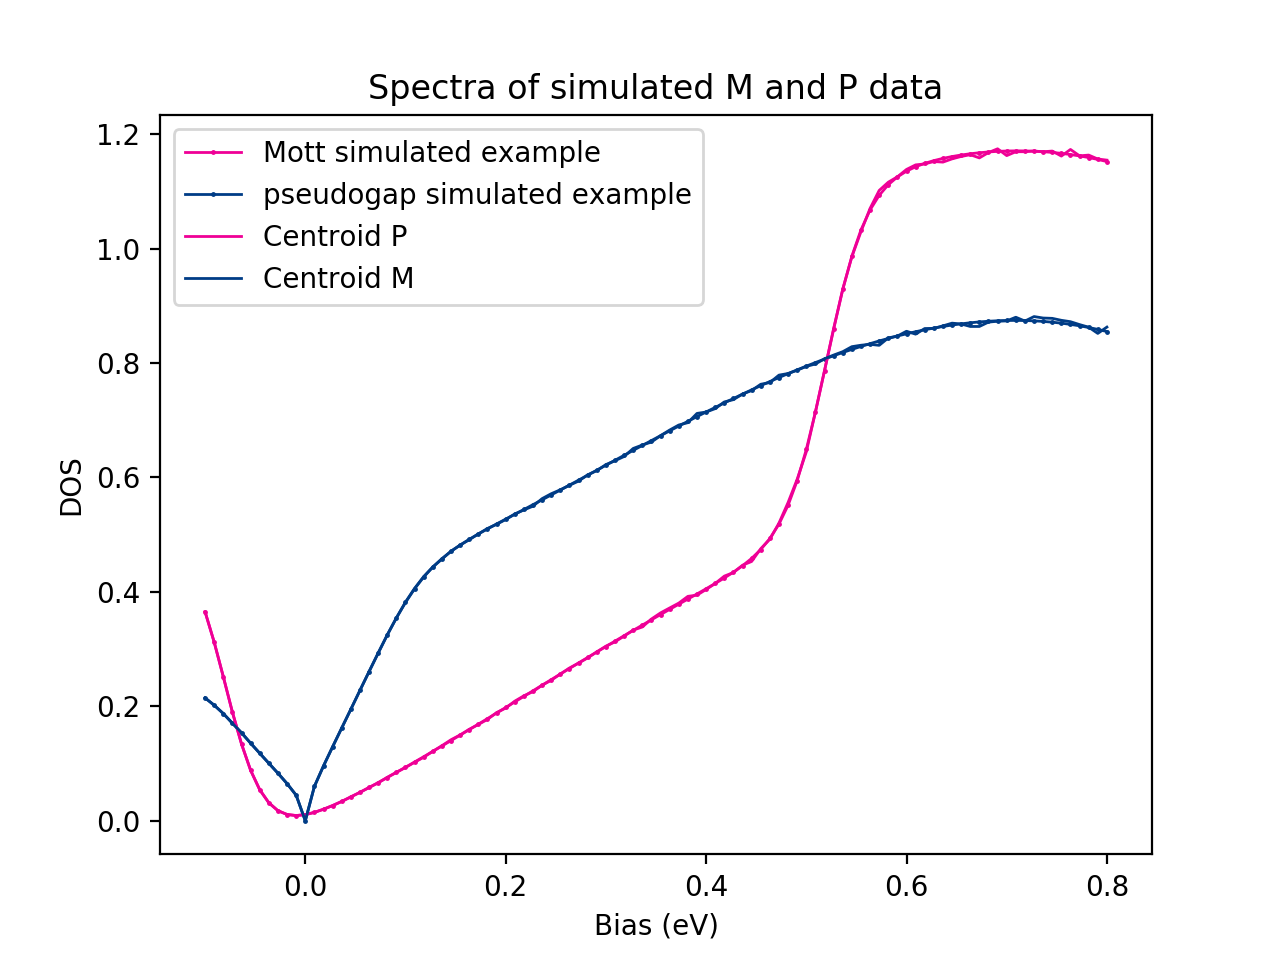

In [281]:
#Plotting
#Note on colour: '#003C86' is navy for P1
#                '#EF0096' is magenta for M
#                'k' is black for DEFFECT
#                '#00DCB5'is teal for P2

fig,(ax1) = plt.subplots()
fig.subplots_adjust(hspace=0.3)
    
ax1.plot(V,true_BM_spectrum,label="Mott simulated example", marker='.',linestyle='-', lw=1, markersize=1.5, color='#EF0096')
ax1.plot(V,true_BP_spectrum,label="pseudogap simulated example", marker='.',linestyle='-', lw=1, markersize=1.5, color='#003C86')

ax1.plot(V,test_centroids[1],label="Centroid P", marker='',linestyle='-', lw=1, color='#EF0096')
ax1.plot(V,test_centroids[0],label="Centroid M", marker='',linestyle='-', lw=1, color='#003C86')


ax1.set_ylabel("DOS")
ax1.set_xlabel("Bias (eV)")
ax1.set_title("Spectra of simulated M and P data")
ax1.legend()
#ax1.set_ylim(-0.5, 2.0)
#ax1.set_xlim(-0.05,0.85)

plt.show()

In [21]:
noise_values = [0.5,1.0,1.5,2.0,2.5,3.0]
test_percentages, test_scores = kmeans_MP_noise_test([c0,c1,c2,c3,c4,M,c5,P,a], V, [50,50], [0.5,0.5], noise_values)
print("Success percentages: ",test_percentages)

Failure percentages:  [100.0, 99.88, 95.16, 80.88, 64.68, 57.440000000000005]


<IPython.core.display.Javascript object>


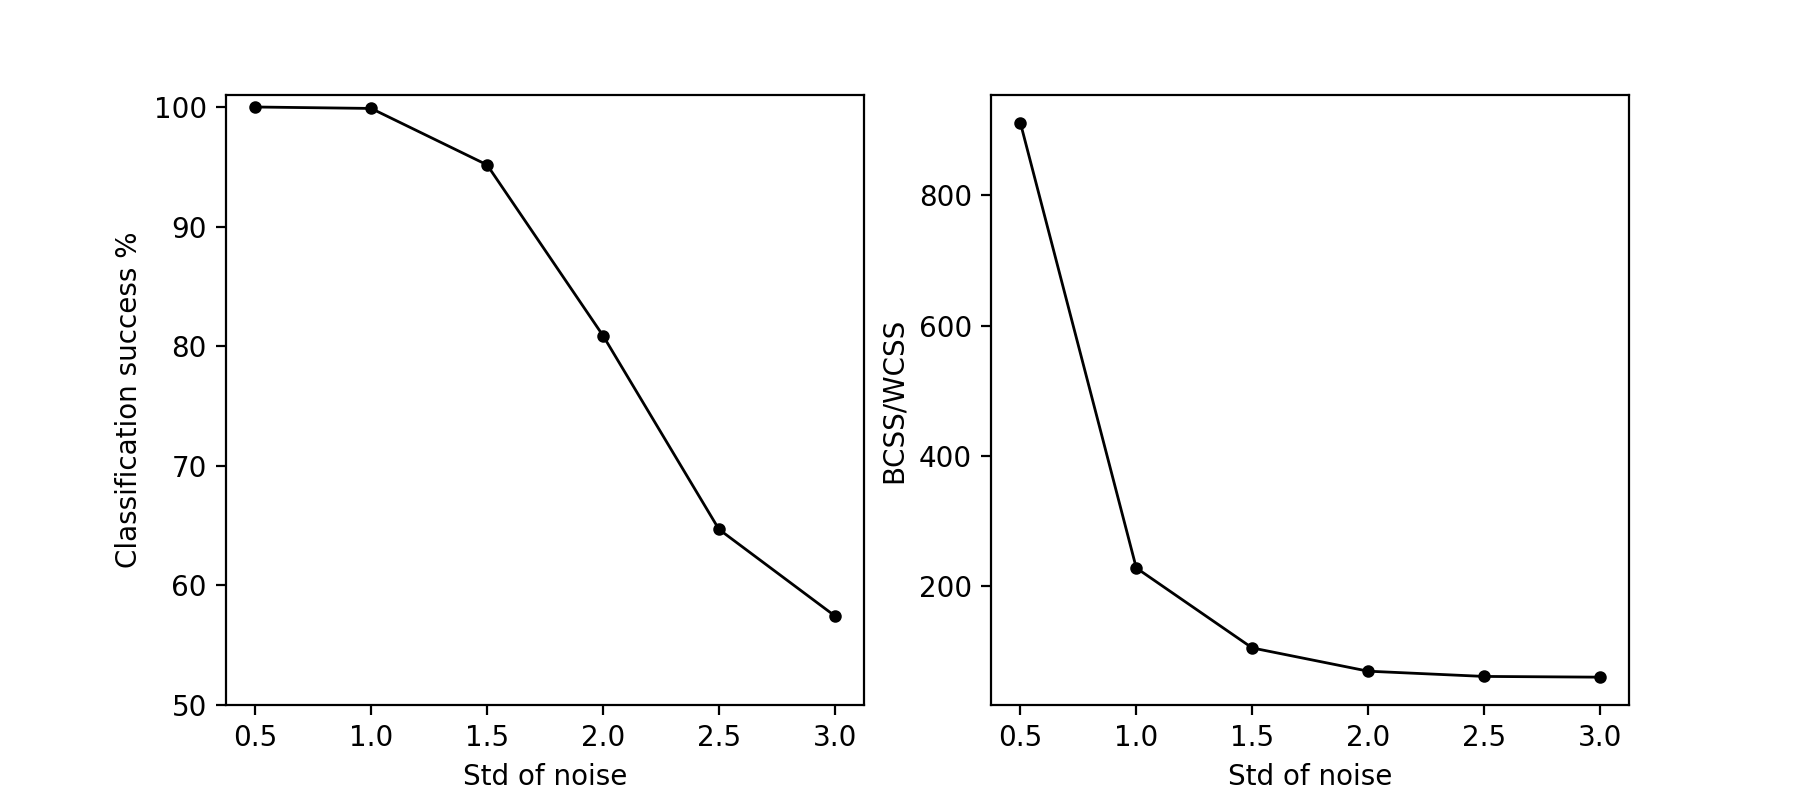

In [24]:
#Plotting
fig,(ax1,ax2) = plt.subplots(1,2)

ax1.plot(noise_values,test_percentages, marker='.',linestyle='-', lw=1, markersize=7, color='k')
ax1.set_ylabel("Classification success %")
ax1.set_xlabel("Std of noise")
ax1.set_ylim(50, 101)

ax2.plot(noise_values,test_scores, marker='.',linestyle='-', lw=1, markersize=7, color='k')
ax2.set_ylabel("BCSS/WCSS")
ax2.set_xlabel("Std of noise")


plt.show()

In [25]:
# Let's try doing k-means on two pseudogap spectra

V = np.linspace(-0.1, 0.8, 100) #0eV to 0.8eV

#Choice values for the function parameters:
c0 = -1.5 #Cubic background term
c1 = 1.0 #Quadratic background term
c2 = 0.85 #Linear background term
c3 = 0.0 #0th order background term

c5_1 = 0.3 #Pseudogap term coeffecient
P_1 = 0.12 #Size of pseudogap in eV
a_1 = 0.2 # depth of pseudogap

c5_2 = 0.5
P_2 = 0.25
a_2 = 0.17

<IPython.core.display.Javascript object>


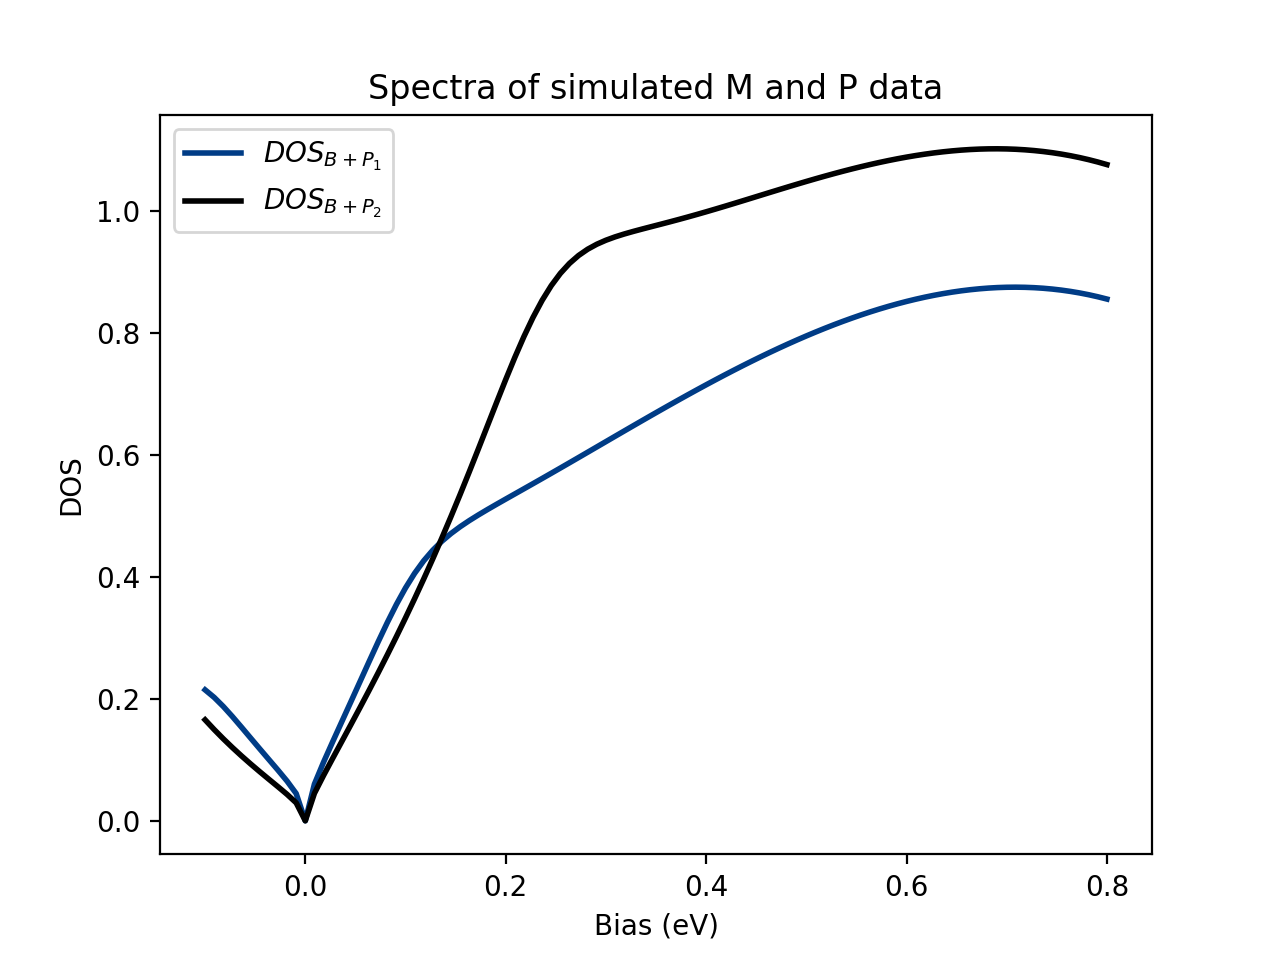

In [26]:
#Import kMeans centroids

sample_dataframe = pd.read_csv("Rh5_4K_4cluster_centroids.csv", sep = ",", header = None)
sample_centroids = sample_dataframe.values
sample_centroids = sample_centroids*1.0E11
sample_energy = np.linspace(-0.8,0.8,81)


#Plotting
#Note on colour: '#003C86' is navy for P1
#                '#EF0096' is magenta for M
#                'k' is black for DEFFECT
#                '#00DCB5'is teal for P2

fig,(ax1) = plt.subplots()
fig.subplots_adjust(hspace=0.3)
    
ax1.plot(V,DOS_BP([c0,c1,c2,c3,c5_1,P_1,a_1],V),label=r"$DOS_{B+P_1}$", marker='',linestyle='-', lw=2, markersize=1.5, color='#003C86')
ax1.plot(V,DOS_BP([c0,c1,c2,c3,c5_2,P_2,a_2],V),label=r"$DOS_{B+P_2}$", marker='',linestyle='-', lw=2, color='k')

ax1.set_ylabel("DOS")
ax1.set_xlabel("Bias (eV)")
ax1.set_title("Spectra of simulated M and P data")
ax1.legend(loc="upper left")
#ax1.set_ylim(-0.2, 1.5)
#ax1.set_xlim(-0.2,0.85)
    

plt.show()


In [27]:
#Simulated pseudogap Data Generator:
#Goal is to generate pseudogap spectra with different parameters
def generate_P_data(params, c5, P, a, V, dimensions, ratio, noise):
    #Inputs:
    #params = [c0, c1, c2, c3]
    #c5 = 1D array, the 2 values of c5 to try.
    #P = 1D array, the 2 values of pseudogap gap size to try.
    #a = 1D array, the 2 values of a to try
    #dimensions = integer array of desired grid map spatial dimensions, [grid x length, grid y length]
    #ratio = array of floats, the probability values for each gap size. Must sum to 1. ie, [0.40, 0.60]
    #noise = float, the standard deviation of gaussian noise added to spectra. 
    
    #Outputs:
    #grid = 3D array [grid width, grid length, bias length] of simulated grid map
    #identities = 2D array [grid width, grid length], of true pixel identities. 0=S[0] gap size, 1=S[1] gap size.
    
    #First, assign random identities:
    rng = np.random.default_rng(12345)#Creating a generator and seeding it
    flat_identities = rng.choice([0,1], size=dimensions[0]*dimensions[1], replace=True, p=ratio)#Choose identities
    identities = np.reshape(flat_identities,(dimensions[0],dimensions[1]))
    
    #Second, generate 'true' grid map
    gap0_spectrum = DOS_BP([params[0],params[1],params[2],params[3],c5[0],P[0],a[0]],V)
    gap1_spectrum = DOS_BP([params[0],params[1],params[2],params[3],c5[1],P[1],a[1]],V)
    
    grid = [[0 for j in range(dimensions[1])] for i in range(dimensions[0])]
    for i in range(dimensions[0]):
        for j in range(dimensions[1]):
            if identities[i][j] == 0: #a.k.a., identity is P0
                grid[i][j] = gap0_spectrum
            else: #a.k.a., identity is P1
                grid[i][j] = gap1_spectrum
    
    #Third, add noise to the spectra
    #Noise is gaussian and proportional to the bias magnitude
    gaussian_noise = rng.normal(loc=0.0, scale=noise, size=(dimensions[0],dimensions[1],len(V)))
    
    grid = grid + V*gaussian_noise
    
    return grid, identities


#Function to run through a range of noise values on simulated pseudogap gridmaps and record the quality of 
#the k-means classification.
def kmeans_P_noise_test(params, c5, P, a, V, dimensions, ratio, noise_values):
    #Inputs:
    #params = [c0, c1, c2, c3]
    #c5 = 1D array, the 2 values of c5 to try.
    #P = 1D array, the 2 values of pseudogap gap size to try.
    #a = 1D array, the 2 values of a to try
    #V = array of bias values
    #dimensions = integer array of desired grid map spatial dimensions, [grid x length, grid y length]
    #ratio = array of floats, the probability values for Mott vs pseudogap pixels. Must sum to 1. ie, [0.40, 0.60]
    #noise_values = array of noise values to test, ie: [0.0, 0.2, 0.4, 0.6]. 
    
    #Outputs:
    #percentages = array of percentage failures values
    
    percentages = [0 for i in range(len(noise_values))]
    scores = [0 for i in range(len(noise_values))]
    
    for i in range(len(noise_values)):
        
        grid, identities = generate_P_data(params, c5, P, a, V, dimensions, ratio, noise_values[i])
        labels, centroids, score = my_kmeans(grid, 2)
        percentage = accuracy_test(identities, labels)
        
        percentages[i] = percentage*100
        scores[i] = score
        
    return percentages, scores

In [28]:
noise_values = [0.5,1.0,1.5,2.0,2.5,3.0]

c5 = [0.3, 0.5]
P = [0.12, 0.25]
a = [0.2, 0.17]

test_percentages, test_scores = kmeans_P_noise_test([c0,c1,c2,c3], c5, P, a, V, [50,50], [0.5,0.5], noise_values)
print("Success percentages: ",test_percentages)

Success percentages:  [100.0, 98.6, 88.75999999999999, 67.44, 58.71999999999999, 55.84]


<IPython.core.display.Javascript object>


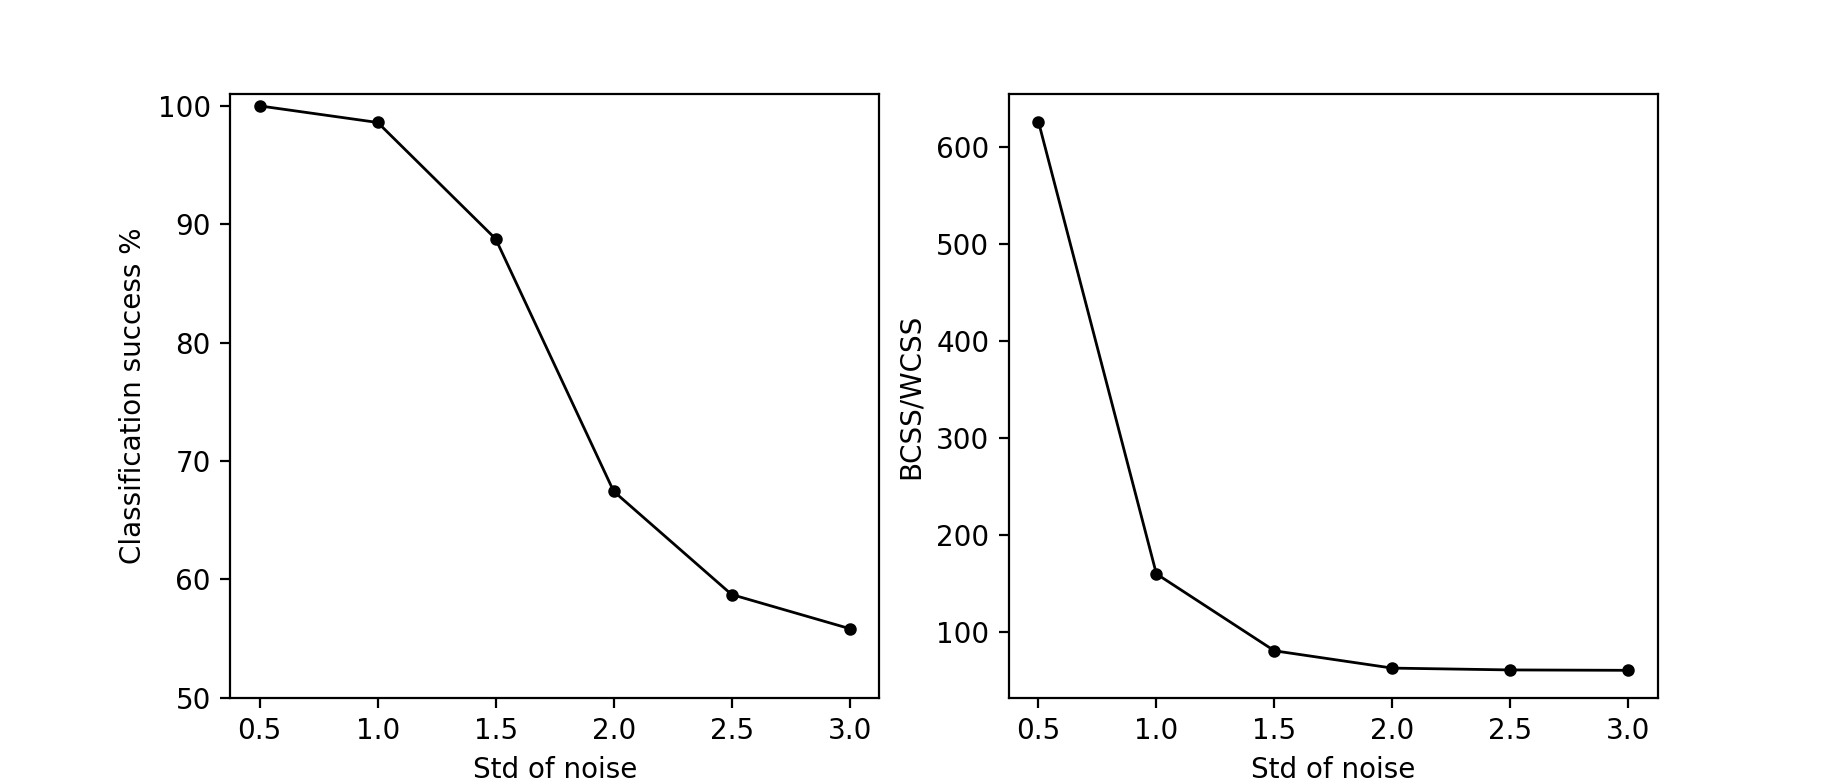

In [31]:
#Plotting
fig,(ax1,ax2) = plt.subplots(1,2)

ax1.plot(noise_values,test_percentages, marker='.',linestyle='-', lw=1, markersize=7, color='k')
ax1.set_ylabel("Classification success %")
ax1.set_xlabel("Std of noise")
#ax1.set_title("Failure rate on simulated data with Gaussian noise")
ax1.set_ylim(50, 101)

ax2.plot(noise_values,test_scores, marker='.',linestyle='-', lw=1, markersize=7, color='k')
ax2.set_ylabel("BCSS/WCSS")
ax2.set_xlabel("Std of noise")
#ax2.set_title("K-means quality of fit score on simulated data with Gaussian noise")

plt.show()

Part 2.<br>
Using the Dynes function to model superconductor spectra.<br>
Taken from: https://journals.aps.org/prb/abstract/10.1103/PhysRevB.94.144508#:~:text=The%20Dynes%20formula%20can%20be%20interpreted%20by%20the,distribution%20of%20pair-breaking%20fields%20and%20arbitrary%20potential%20disorder.<br>

$N(\omega) = N_0\mathbb{R}\left[\frac{\omega+i\Gamma}{\sqrt{\left(\omega + i\Gamma \right)^2 - \bar{\Delta}^2}}\right]$ <br>

$\bar{\Delta}$ is the superconducting gap size. <br>
$\Gamma$ quantifies the effect of the pair-breaking processes. <br>
$N_0$ is the normal-state DOS at the fermi level, and for an arbitrary spectrum can be set to 1.<br>
$N(\omega)$ is the DOS

In [51]:
#Dynes function = DOS_Superconductor
def Dynes(params, V): # params = [G, S]
    G = params[0] #Gamma
    S = params[1] #delta bar, the superconducting gap size
    
    answer = np.abs(np.real( (V+1j*G) / np.sqrt((V+1j*G)**2 - S**2)))
    return answer
    

#Simulated superconductor Data Generator:
#Goal is to generate superconducting spectra with slightly different gap sizes
def generate_superconductor_data(G, S, V, dimensions, ratio, noise):
    #Inputs:
    #G = 1D array, the 2 values of Gamma to try.
    #S = 1D array, the 2 values of superconducting gap size to try.
    #V = 1D array of bias values
    #dimensions = integer array of desired grid map spatial dimensions, [grid x length, grid y length]
    #ratio = array of floats, the probability values for each gap size. Must sum to 1. ie, [0.40, 0.60]
    #noise = float, the standard deviation of gaussian noise added to spectra. 
    
    #Outputs:
    #grid = 3D array [grid width, grid length, bias length] of simulated grid map
    #identities = 2D array [grid width, grid length], of true pixel identities. 0=S[0] gap size, 1=S[1] gap size.
    
    #First, assign random identities:
    rng = np.random.default_rng(12345)#Creating a generator and seeding it
    flat_identities = rng.choice([0,1], size=dimensions[0]*dimensions[1], replace=True, p=ratio)#Choose identities
    identities = np.reshape(flat_identities,(dimensions[0],dimensions[1]))
    
    #Second, generate 'true' grid map
    gap0_spectrum = Dynes([G[0],S[0]],V)
    gap1_spectrum = Dynes([G[1],S[1]],V)
    
    grid = [[0 for j in range(dimensions[1])] for i in range(dimensions[0])]
    for i in range(dimensions[0]):
        for j in range(dimensions[1]):
            if identities[i][j] == 0: #a.k.a., identity is Mott
                grid[i][j] = gap0_spectrum
            else: #a.k.a., identity is pseudogap
                grid[i][j] = gap1_spectrum
    
    #Third, add noise to the spectra
    #Noise is gaussian and proportional to the bias magnitude
    gaussian_noise = rng.normal(loc=0.0, scale=noise, size=(dimensions[0],dimensions[1],len(V)))
    
    grid = grid + V*gaussian_noise
    
    return grid, identities

#Function to run through a range of noise values on superconductor simulated data and record the quality of 
#the k-means classification.
def kmeans_S_noise_test(G, S, V, dimensions, ratio, noise_values):
    #Inputs:
    #G = 1D array, the 2 values of Gamma to try.
    #S = 1D array, the 2 values of superconducting gap size to try.
    #V = array of bias values
    #dimensions = integer array of desired grid map spatial dimensions, [grid x length, grid y length]
    #ratio = array of floats, the probability values for Mott vs pseudogap pixels. Must sum to 1. ie, [0.40, 0.60]
    #noise_values = array of noise values to test, ie: [0.0, 0.2, 0.4, 0.6]. 
    
    #Outputs:
    #percentages = array of percentage failures values
    
    percentages = [0 for i in range(len(noise_values))]
    scores = [0 for i in range(len(noise_values))]
    
    for i in range(len(noise_values)):
        grid, identities = generate_superconductor_data(G, S, V, dimensions, ratio, noise_values[i])
        labels, centroids, score = my_kmeans(grid, 2)
        percentage = accuracy_test(identities, labels)
        
        percentages[i] = percentage*100
        scores[i] = score
        
    return percentages, scores

In [52]:
#Define bias values
V = np.linspace(-3, 3, 200) #0eV to 0.8eV

#Choice values for the function parameters:
G = [0.2,0.2] #Based roughly on values from Herman and Hlubina paper
S = [0.1,0.5]

grid_x = 50 #How many pixels in x
grid_y = 50 #How many pixels in y

true_S0_spectrum = Dynes([G[0],S[0]],V)
true_S1_spectrum = Dynes([G[1],S[1]],V)

In [53]:
S_grid, S_identities = generate_superconductor_data(G, S, V, [grid_x,grid_y],[0.5,0.5],0.64)
example_S0 = S_grid[0][0]
example_S1 = S_grid[10][10]
S_labels, S_centroids, S_scores = my_kmeans(S_grid, 2)


<IPython.core.display.Javascript object>


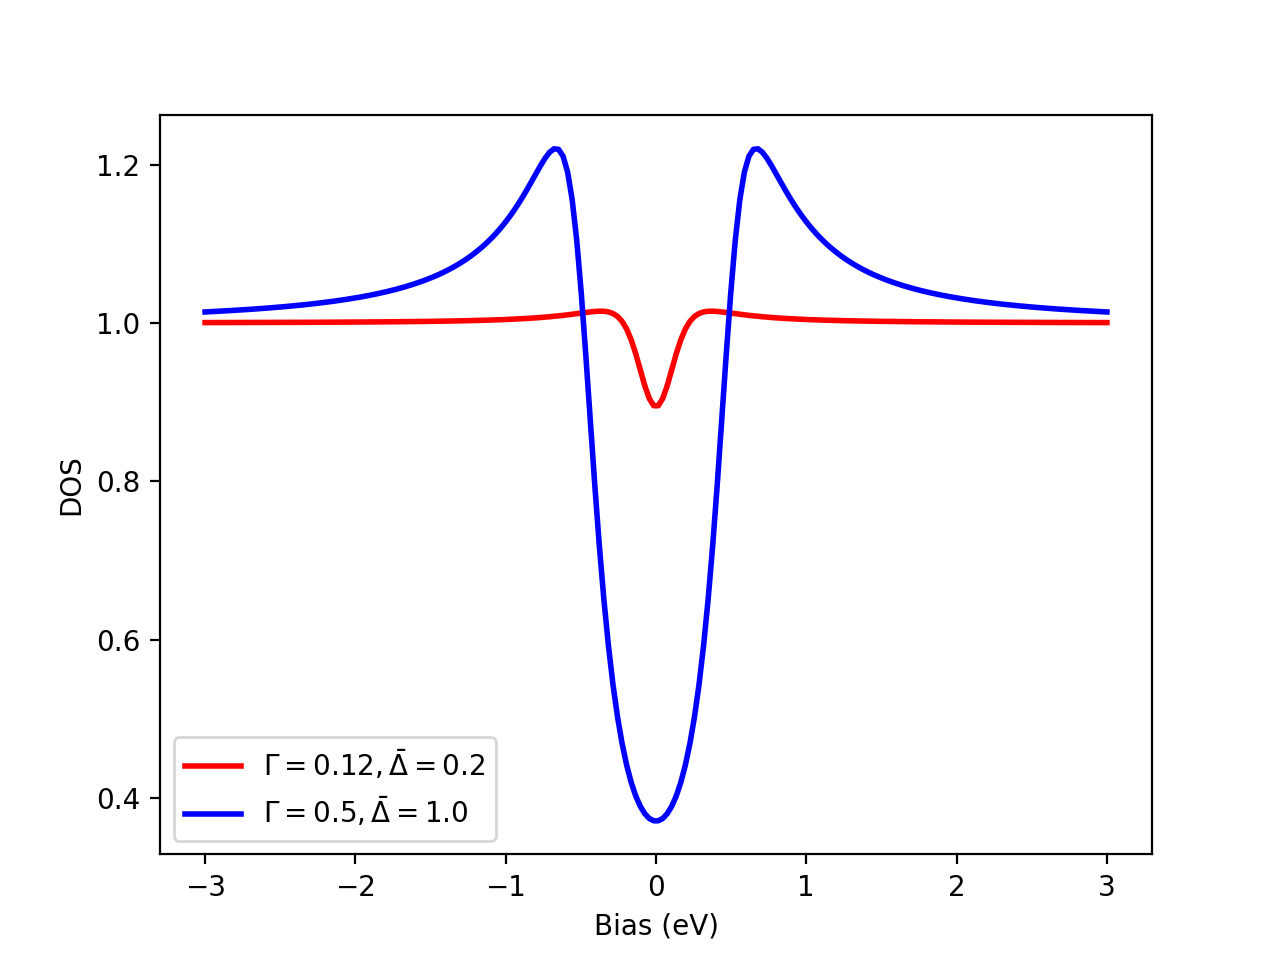

In [54]:
#Plotting
fig,(ax) = plt.subplots()
    
ax.plot(V,true_S0_spectrum,label=r"$\Gamma=0.12, \bar{\Delta}=0.2$", marker='',linestyle='-', lw=2, markersize=1.5, color='red')
ax.plot(V,true_S1_spectrum,label=r"$\Gamma=0.5, \bar{\Delta}=1.0$", marker='',linestyle='-', lw=2, markersize=1.5, color='blue')
#ax.plot(V,S_centroids[1],label="S0 Centroid", marker='', linestyle='-',lw=2,markersize=2, color='orange')
#ax.plot(V,S_centroids[0],label="S1 Centroid", marker='', linestyle='-',lw=2,markersize=2, color='cyan')
#ax.plot(V,example_S0, label='example S0 with noise std=0.64', marker='.',linestyle='-', lw=1, markersize=1.5, color='red')
#ax.plot(V,example_S1, label='example S1 with noise std=0.64', marker='.',linestyle='-', lw=1, markersize=1.5, color='blue')

ax.set_ylabel("DOS")
ax.set_xlabel("Bias (eV)")
#ax.set_title("Failure rate 46.12%")
ax.legend(loc="lower left")

plt.show()

In [55]:
noise_values = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
S_percentages, S_scores = kmeans_S_noise_test(G, S, V, [grid_x,grid_y], [0.5,0.5], noise_values)
print("Success percentages: ",S_percentages)

Success percentages:  [100.0, 100.0, 100.0, 100.0, 56.64, 52.839999999999996, 51.92, 51.12]


<IPython.core.display.Javascript object>


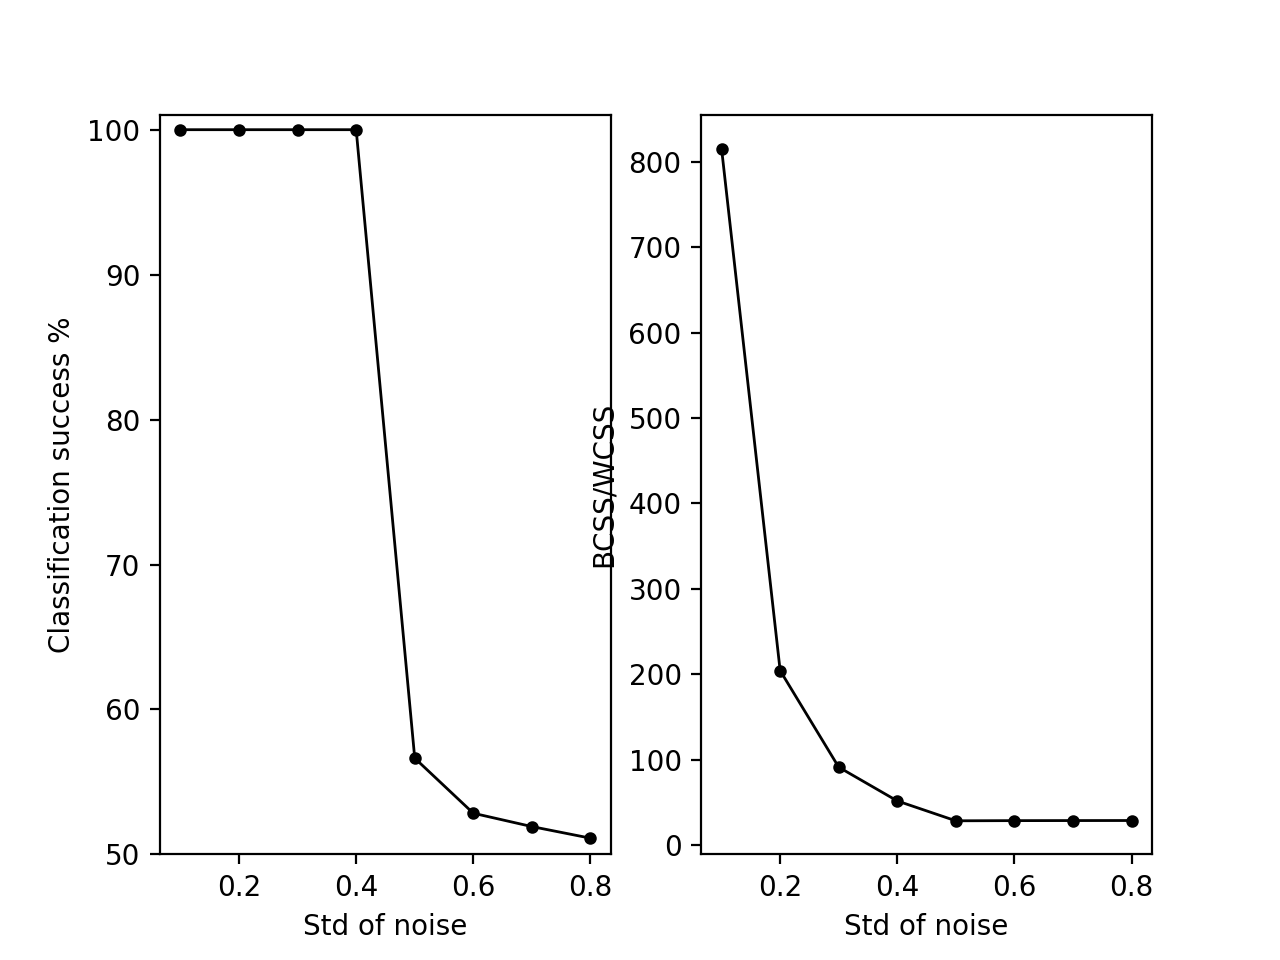

In [56]:
#Plotting
fig,(ax1,ax2) = plt.subplots(1,2)

ax1.plot(noise_values,S_percentages, marker='.',linestyle='-', lw=1, markersize=7, color='k')
ax1.set_ylabel("Classification success %")
ax1.set_xlabel("Std of noise")
#ax1.set_title("Failure rate on simulated data with Gaussian noise")
ax1.set_ylim(50, 101)

ax2.plot(noise_values,S_scores, marker='.',linestyle='-', lw=1, markersize=7, color='k')
ax2.set_ylabel("BCSS/WCSS")
ax2.set_xlabel("Std of noise")
#ax2.set_title("K-means quality of fit score on simulated data with Gaussian noise")

plt.show()

In [68]:
#Function to find the catastrophe point for a given difference in delta and energy resolution
def catastrophe_finder(gap_delta, energy_resolution, G, minV, maxV, dimensions, ratio):
    #Inputs:
    #gap_delta = float, the difference in S gap values to test
    #energy_resolution = integer, the number of V values in data (ie: length of linspace)
    #G = 1D array, the 2 values of Gamma to try.
    #minV = float of first V value
    #maxV = float of last V value
    #dimensions = integer array of desired grid map spatial dimensions, [grid x length, grid y length]
    #ratio = array of floats, the probability values for Mott vs pseudogap pixels. Must sum to 1. ie, [0.40, 0.60]
    
    #Outputs:
    #noise = float, noise values where kmeans failed
    
    V = np.linspace(minV, maxV, energy_resolution)
    S0 = 0.1
    S1 = S0 + gap_delta
    S = [S0, S1]
    percentages = [0 for i in range(30)]
    
    for i in range(30): #Hardcoding it to stop at a std of 3.0.
        noise = 0.05*i
        grid, identities = generate_superconductor_data(G, S, V, dimensions, ratio, noise)
        labels, centroids, score = my_kmeans(grid, 2)
        percentage = accuracy_test(identities, labels)
        percentages[i] = percentage*100
        
        if (percentages[i-1]-percentages[i]) > 25.0: #Then we can call it a catastrophe
            return noise
        
    print("Reached a noise value of ",noise," and no catastrophe found.")   
    return 0.0
        

#Function to map catastrophe points in the space of difference in delta vs energy resolution
def catastrophe_mapper(gap_delta_values, energy_resolution_values, G, minV, maxV, dimensions, ratio):
    #Inputs:
    #gap_delta_values = array of floats, list of difference in gap values to test
    #energy_resolution_values = array of integers, list of the number of V values in data (ie: length of linspace)

    #G = 1D array, the 2 values of Gamma to try.
    #minV = float of first V value
    #maxV = float of last V value
    #dimensions = integer array of desired grid map spatial dimensions, [grid x length, grid y length]
    #ratio = array of floats, the probability values for Mott vs pseudogap pixels. Must sum to 1. ie, [0.40, 0.60]
    
    #Outputs:
    #catastrophe_points = 2D array of floats, noise values where kmeans failed
    
    
    catastrophe_points = [[0 for j in range(len(energy_resolution_values))] for i in range(len(gap_delta_values))]
    
    for i in range(len(gap_delta_values)):
        for j in range(len(energy_resolution_values)):
            catastrophe_points[i][j] = catastrophe_finder(gap_delta_values[i], energy_resolution_values[j], 
                                                          G, minV, maxV, dimensions, ratio)
    
    return catastrophe_points

In [76]:
#Computing:
G = [0.2,0.2] 
dimensions = [50, 50]
ratio = [0.5, 0.5]
gap_delta_values = [0.1,0.2,0.3,0.4,0.5]
energy_resolution_values = [100, 120, 140, 160, 180, 200]
minV = -3.0
maxV = 3.0

catastrophe_map = catastrophe_mapper(gap_delta_values, energy_resolution_values, G, minV, maxV, dimensions, ratio)

In [82]:
energy_resolution_in_V = np.abs(maxV - minV) / energy_resolution_values
energy_resolution_in_G = energy_resolution_in_V / G[0] #[G] = V * [1 G / 0.2 V]
print(energy_resolution_in_G)

[0.3        0.25       0.21428571 0.1875     0.16666667 0.15      ]


<IPython.core.display.Javascript object>


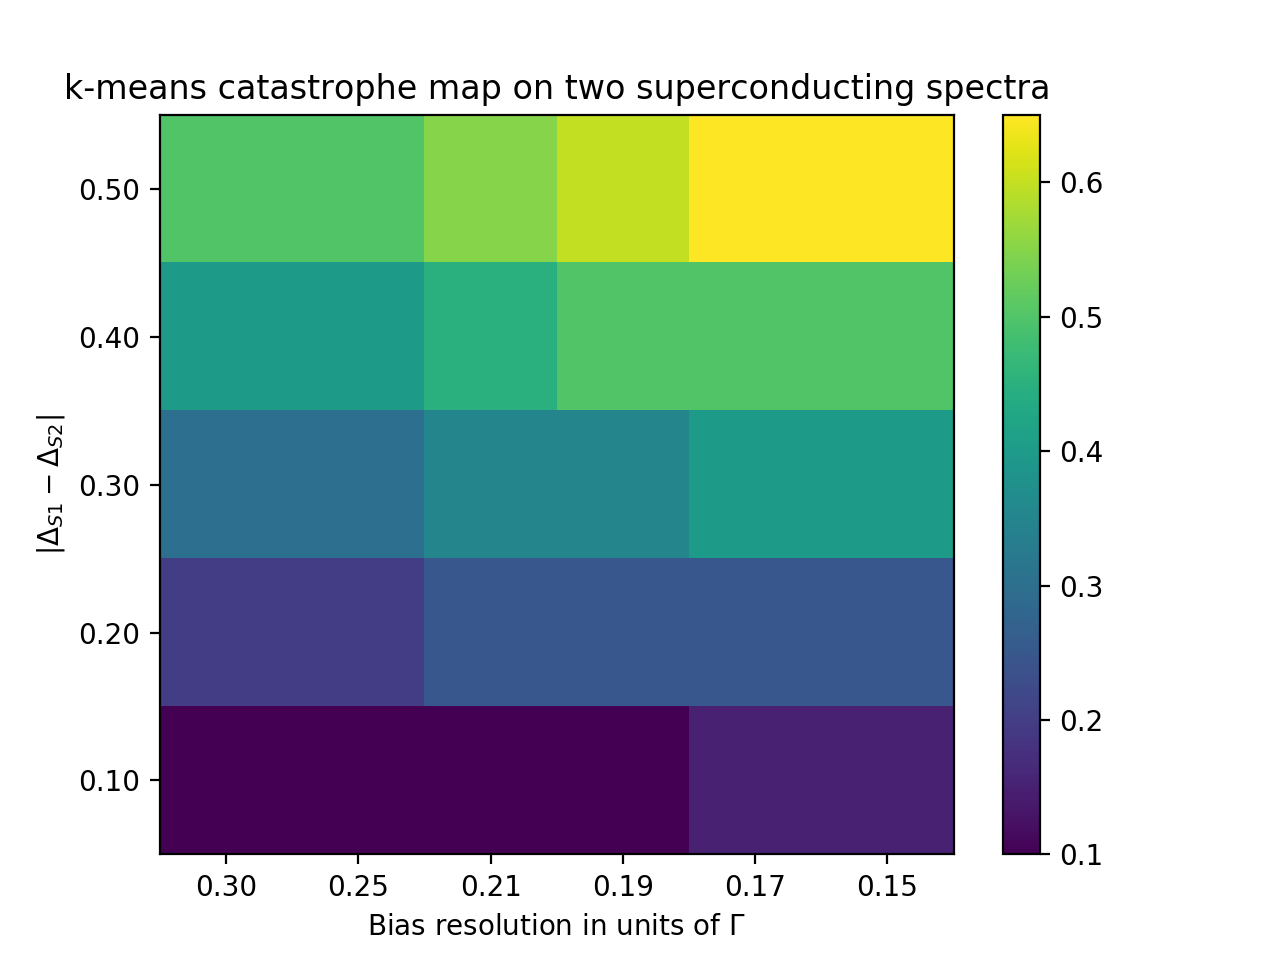

In [88]:
#Plotting
image = plt.imshow(catastrophe_map, origin='lower', aspect='auto')

plt.colorbar(image)
plt.title("k-means catastrophe map on two superconducting spectra")
plt.xlabel(r"Bias resolution in units of $\Gamma$")
plt.ylabel(r"$\left|\Delta_{S1} - \Delta_{S2}\right|$")

energy_resolution_in_G_str = ["%.2f" % i for i in energy_resolution_in_G]
gap_delta_values_str = ["%.2f" % i for i in gap_delta_values]
plt.xticks([0,1,2,3,4,5],energy_resolution_in_G_str)
plt.yticks([0,1,2,3,4],gap_delta_values_str)
plt.show()
